<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/START_HERE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [ ]:
!pip install rapidae

This installs the latest stable version. If you want to have control over the code you can check the [execute_from_source_code]("https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/execute_from_source_code.ipynb") notebook.

You will also need to install a backend framework

**If you are executing this from colab you can skip this process**, Tensorflow, Pytorch and JAX are already installed.

#### Install tensorflow

In [ ]:
!python3 -m pip install tensorflow[and-cuda]

After installing tensorflow Keras 3 should be re-installed. This is a temporary step while TensorFlow is pinned to Keras 2, and will no longer be necessary after TensorFlow 2.16. The cause is that tensorflow==2.15 will overwrite your Keras installation with keras==2.15.

In [ ]:
!pip install --upgrade keras

#### Install pytorch

In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

#### Install JAX

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]" # CPU-only version
# pip install --upgrade "jax[cuda11_pip]" # NVIDIA GPU version

REMOVE

In [16]:
import os
import sys

notebook_dir = os.path.abspath('') # get the current notebook directory
sys.path.append(os.path.join(notebook_dir, '..', 'src')) # add src folder to path to import modules

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

Let´s start loading some data.

You can list the available datasets with the ```list_datasets()``` function.

In [19]:
from rapidae.data import list_datasets, load_dataset, load_MNIST

In [20]:
list_datasets()

['AtrialFibrillation', 'CMAPSS', 'MNIST']

Then, there are two options for loading a dataset:

1. Use the load_dataset function with the dataset name

In [21]:
data = load_dataset('MNIST')

2024-01-26 20:34:20 [INFO]: Downloading train-images-idx3-ubyte.gz...
2024-01-26 20:34:21 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-01-26 20:34:21 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-01-26 20:34:21 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-01-26 20:34:22 [INFO]: Deleting MNIST data...


2. Use the load_"dataset_name" function. 

In [22]:
data = load_MNIST() # persistant=True stores the data

2024-01-26 20:34:23 [INFO]: Downloading train-images-idx3-ubyte.gz...
2024-01-26 20:34:24 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-01-26 20:34:24 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-01-26 20:34:24 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-01-26 20:34:24 [INFO]: Deleting MNIST data...


All datasets have a "persistant" parameter. If set to True stores the data in a newly created "datasets" folder. By default it is set to False.

```

data = load_dataset('MNIST', persistant=True)
data = load_MNIST(persistant=True)

```

All datasets return a dictionary with can contain any of the following keys:
- x_train
- x_val
- x_test
- y_train
- y_val
- y_test

In [23]:
data.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test'])

In [24]:
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']

Prepare data for training:
- Normalize data in the range [0,1]
- Convert labels to categorical

In [25]:
from keras import utils

# Normalize data and flatten images
x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255

input_dim = x_train.shape[1]

# Convert labels to categorical
n_classes = len(set(y_train))
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

### Models

You can list available models with the ```list_models()``` function.

Note however, that these are the base models, for a complete guide of the implemented models, please refer to the documentation or to the README of the official repo.

In [14]:
from rapidae.models import list_models

In [15]:
list_models()

['AE', 'BASE', 'CAE', 'RVE', 'VAE', 'VQ_VAE']

Let´s build a vanilla autoencoder.

Each model needs typically an encoder and a decoder (some models actually don´t, but let´s skip that part). You can select among the available architectures in the models module or provide your own implementation.

#### 1. Selecting an existing architecture

In [17]:
from rapidae.models import AE

Each model has at least the following parameters:

- input_dim (Union[Tuple[int, ...], None]): The dimensionality of the input data. Default is None. **Required parameter**.
    This typically is:
    - If time series: series_len, num_features
    - If image: width, height, num_channels
    - If the selected model uses a Dense layer as the first layer it should be the product of those dimensions. In this case, for instance, width=28, height=28, num_channels=1 but the input_dim is 28x28x1=784
- latent_dim (int): The dimensionality of the latent space. Default is 2.
- encoder (BaseEncoder): An instance of BaseEncoder. Default is None.
- decoder (BaseDecoder): An instance of BaseDecoder. Default is None.
- exclude_decoder (bool): Whether to exclude the decoder from the model. Default is False.
- layers_conf (list): The configuration of layers in the encoder and decoder architectures. Default is None. *Only applies for MLP architectures.*

You can notice that the input_dim is the only required parameter, which means you can instantiate a model just by doing:

In [26]:
model = AE(input_dim=input_dim)

2024-01-26 20:34:38 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...
2024-01-26 20:34:38 [WARNING]: No encoder provided, using default encoder


Feel free to experiment with other parameters. For example, we can also set:
- latent_dim: number of neurons in the latent space (bottleneck).
- layers_conf: by setting [32,64,128] we specify that we want an encoder with 3 layers and the number of neurons for each layer should be 32 for the first, 64 for the second and 128 for the third. The decoder has the same structure but in reverse, that is, 3 layers with 128, 64, 32 neurons in each one.

In [18]:
model = AE(input_dim=input_dim, latent_dim=5, layers_conf=[32, 64, 128])

2024-01-22 21:31:27 [WARNING]: No encoder provided, using default encoder
2024-01-22 21:31:27 [WARNING]: No decoder provided, using default decoder


Finally, you can also select an existing architecture:

In [21]:
from rapidae.models.base import VanillaEncoder, VanillaDecoder

In [22]:
model = AE(input_dim=input_dim, encoder=VanillaEncoder, decoder=VanillaDecoder)

2024-01-22 21:34:31 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...


#### 2. Providing a custom architecture

Let's say you want another model architecture, then you would have to define it yourself, here is an example:

In [23]:
from rapidae.models import BaseEncoder, BaseDecoder
from keras import layers

class Custom_Encoder(BaseEncoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseEncoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = layers.Dense(300)
        self.layer_2 = layers.Dense(150)
        self.layer_3 = layers.Dense(self.latent_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

class Custom_Decoder(BaseDecoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseDecoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = layers.Dense(self.latent_dim)
        self.layer_2 = layers.Dense(self.input_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

Now instantiate the model as before

In [24]:
model = AE(input_dim=input_dim, encoder=Custom_Encoder, decoder=Custom_Decoder)

### Training

The model is a keras model therefore you can directly use the ```.fit``` method.

The training pipeline allows you to configure training settings like managing callbacks or reloading the best parameters after tranining.

It has the following parameters:
- model (BaseAE): Autoencoder model to be trained.
- optimizer (str): Name of the optimizer.>
- learning_rate (float): Learning rate for the optimizer.
- batch_size (int): Batch size for training.
- num_epochs (int): Number of training epochs.
- callbacks (list, optional): List of Keras callbacks. Defaults to None.
- save_model (bool, optional): Flag to save the trained model. Defaults to True.

In [25]:
from rapidae.pipelines import TrainingPipeline

In [26]:
pipe = TrainingPipeline(name='vanilla_autoencoder', learning_rate=0.01,
                        model=model, num_epochs=20, batch_size=128)

trained_model = pipe(x=x_train, y=x_train)

2024-01-22 21:39:05 [INFO]: +++ vanilla_autoencoder +++
2024-01-22 21:39:05 [INFO]: Creating folder in ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05
2024-01-22 21:39:06.078156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 21:39:06.604374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 21:39:06.604438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 21:39:06.621407: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/p

Epoch 1/20


2024-01-22 21:39:16.621740: I external/local_xla/xla/service/service.cc:168] XLA service 0x55b9fe355250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 21:39:16.622116: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-22 21:39:16.788734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-22 21:39:22.721368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-22 21:39:22.805026: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1705955964.750101  626521 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: loss improved from inf to 0.07659, saving model to ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05/model.weights.h5
469/469 - 11s - 24ms/step - loss: 0.0766
Epoch 2/20

Epoch 2: loss improved from 0.07659 to 0.05706, saving model to ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0571
Epoch 3/20

Epoch 3: loss improved from 0.05706 to 0.05646, saving model to ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0565
Epoch 4/20

Epoch 4: loss improved from 0.05646 to 0.05614, saving model to ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0561
Epoch 5/20

Epoch 5: loss improved from 0.05614 to 0.05607, saving model to ./output_dir/vanilla_autoencoder_2024-01-22_21-39-05/model.weights.h5
469/469 - 1s - 2ms/step - loss: 0.0561
Epoch 6/20

Epoch 6: loss did not improve from 0.05607
469/469 - 1s - 2ms/step - loss: 0

2024-01-22 21:39:40 [INFO]: Restoring best model
2024-01-22 21:39:40 [INFO]: Best model restored


### Evaluation

Depending on what you are training the model for you can find different evaluations. For this example we are going to focus on the visual evaluation of the latent space as well as in the decoder´s reconstructions.

In [27]:
from rapidae.evaluate import plot_reconstructions, plot_latent_space

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


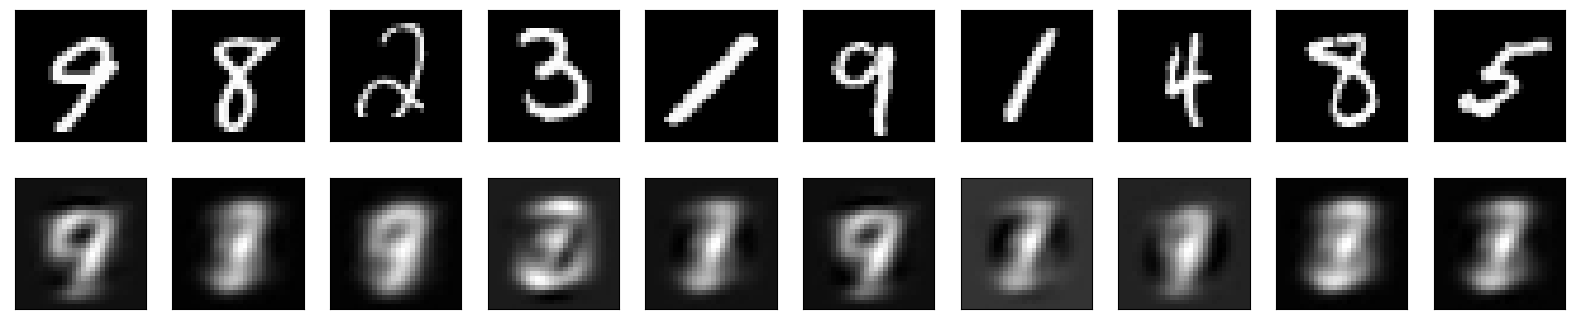

In [28]:
outputs = trained_model.predict(x_test)

plot_reconstructions(x_test, outputs['recon'])

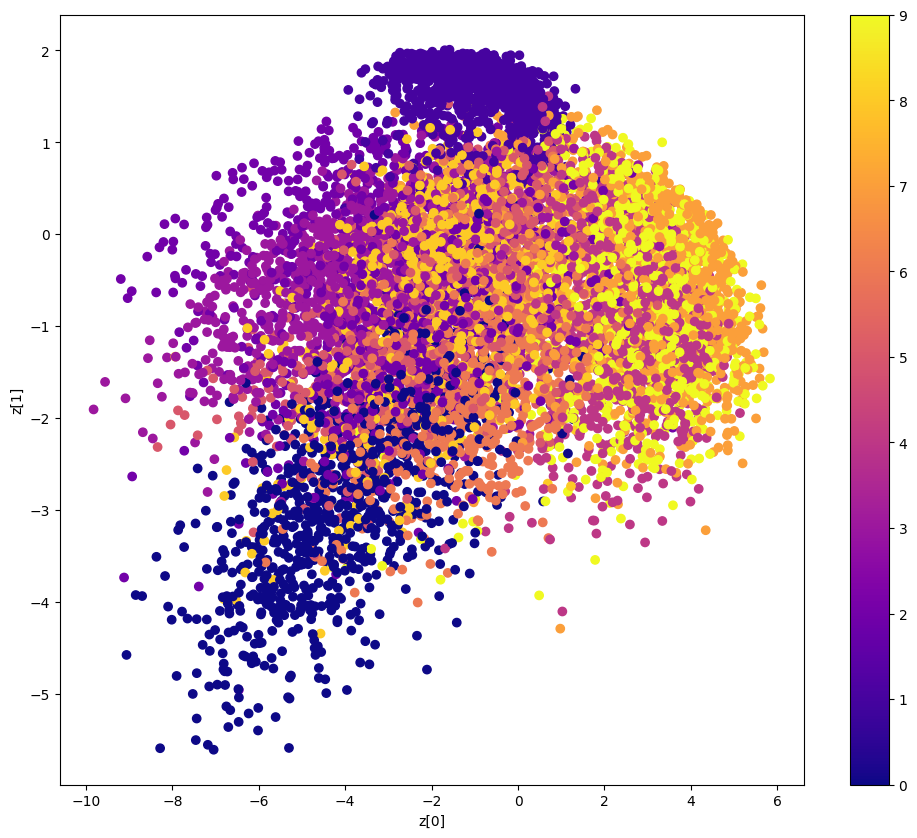

: 

In [39]:
plot_latent_space(outputs['z'], y_test.argmax(axis=1))